### PSC overexpression example

This notebook prepares a dataset with hundreds of individual overexpression experiments applied to pluripotent stem cells ([Nakatake et al 2020](https://www.sciencedirect.com/science/article/pii/S2211124720306082)). This choice of dataset is meant to be an easy starting point: the time-scale (48 hours) is fairly short-term, the cell state (pluripotency) is well studied,  and the perturbations are numerous (714 genes including 481 TF's). The dataset is also small (~1k samples) so testing/debugging is fast. 

The data contain both microarray and RNA-seq measurements, but these have already been effectively integrated by the authors using a strategy akin to quantile normalization. There are missing values marked -9999, which include genes missing from microarrays and outlying measurements censored by the creators. For now, missing values are being filled in with control gene expression. There are three types of negative control *samples*, labeled "control", "emerald", and "CAG-rtTA35-IH". We use mostly "control". 

Here we tidy the PSC overexpression dataset and carry out a simple exploration in scanpy. (It's not single cell data but scanpy is clearly a useful place to start.) 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import sys
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
from scipy.stats import spearmanr as spearmanr
from scipy.stats import pearsonr
import itertools as it
import anndata

from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.oneway import anova_oneway
from sklearn.metrics import mutual_info_score
import time
from collections import Counter


# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# I prefer to specify the working directory explicitly.
os.chdir("/home/gary/cahan_rotation/perturbation_data")

### Reshape the data

In [2]:
expression_quantified = pd.read_csv("not_ready/ko_esc/CREST_06162021.txt", 
                                    delimiter="\t",
                                    index_col=0, 
                                    header=0, 
                                    comment = '!') 

In [3]:
gene_metadata   = expression_quantified.iloc[:,-4:]
expression_quantified = expression_quantified.iloc[:, 0:-4].T
sample_metadata = pd.DataFrame(columns = ["perturbation"], 
                               index = expression_quantified.index,
                               data = [re.sub("\..", "", g) for g in expression_quantified.index])

expression_quantified = sc.AnnData(expression_quantified, 
                                   var = gene_metadata,
                                   obs = sample_metadata)
expression_quantified.raw = expression_quantified.copy()

In [4]:
# Document controls with weird names
""" Emerald : Transgene w/ fluophore only
    Control : median gene expression
    CAG-rtTA35-IH : hESC cell line """
controls = ("Emerald", "Control", "CAG-rtTA35-IH")
for c in controls:
    assert c in sample_metadata['perturbation'].unique() 
expression_quantified.obs["is_control"] = expression_quantified.obs['perturbation'].isin(controls)

### Count and Impute missing entries

Most but not all of the missingness is due to microarrays capturing fewer genes than RNA-seq.

Some is due to Nakatake et al. removing outliers. 

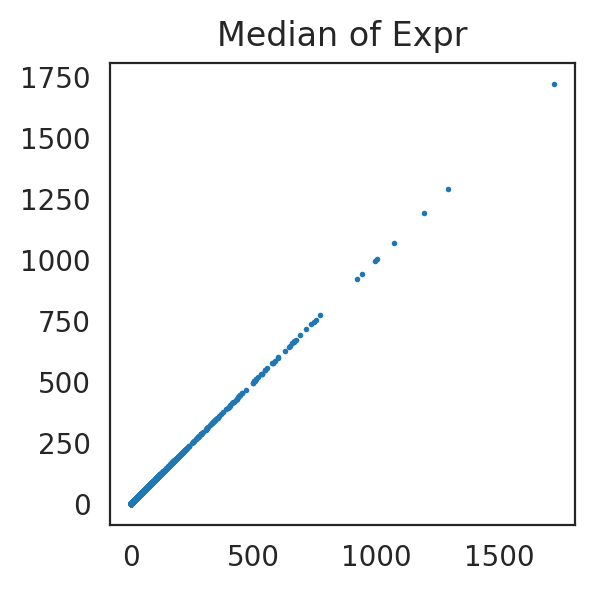

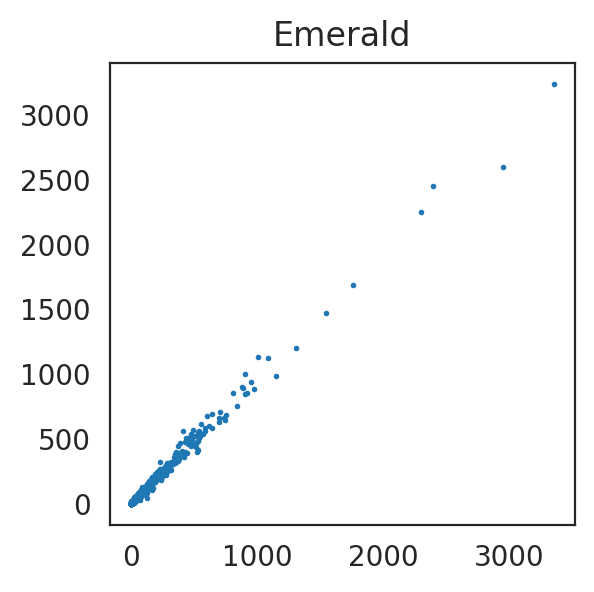

In [5]:
""" Two controls have identical expression levels except for 
genes that are missing in the microarrays. """
plt.figure(figsize=(3,3))
controlExpr = expression_quantified.X[expression_quantified.obs.perturbation == "Control" ,:]
controlExpr = controlExpr[:, ~(controlExpr[1,:] == -9999)]
plt.scatter(controlExpr[0,:], controlExpr[1,:], s=1)
plt.title("Median of Expr")
plt.show()

plt.figure(figsize=(3,3))
controlExpr = expression_quantified.X[expression_quantified.obs.perturbation == "Emerald" ,:]
controlExpr = controlExpr[:, ~(controlExpr[1,:] == -9999)]
plt.scatter(controlExpr[0,:], controlExpr[1,:], s=1)
plt.title("Emerald")
plt.show()

In [6]:
missing = expression_quantified.X==-9999
expression_quantified.obs["fraction_missing"] = missing.mean(axis=1)
expression_quantified.var["fraction_missing"] = missing.mean(axis=0)
controlIndex = expression_quantified.obs.index=="Control"
for i in range(len(expression_quantified.obs.index)):
    missing_i = np.squeeze(expression_quantified[i,:].X==-9999)
    expression_quantified.X[i,missing_i] = expression_quantified.X[controlIndex,missing_i]

In [7]:
display(pd.DataFrame(
    pd.DataFrame(
        expression_quantified.obs.fraction_missing.tolist(), 
        columns=["% Gene Missing"])
    .value_counts(), 
    columns=["Such # of Clones"]))

display(pd.DataFrame(
    pd.DataFrame(
        expression_quantified.var.fraction_missing.tolist(), 
        columns=["% Clone Missing"])
    .value_counts(), 
    columns=["Such # of Genes"]))

Such # of Clones
% Gene Missing                  
0.000000                     844
0.192786                     149
0.000040                       4
0.000159                       2
0.000239                       2
0.000279                       2
0.000080                       1
0.000120                       1
0.000359                       1
0.000917                       1
0.001993                       1
0.193105                       1
0.193224                       1
0.194739                       1
0.195496                       1

Such # of Genes
% Clone Missing                 
0.000000                   20032
0.151186                    4804
0.000988                     214
0.152174                      33
0.001976                       7

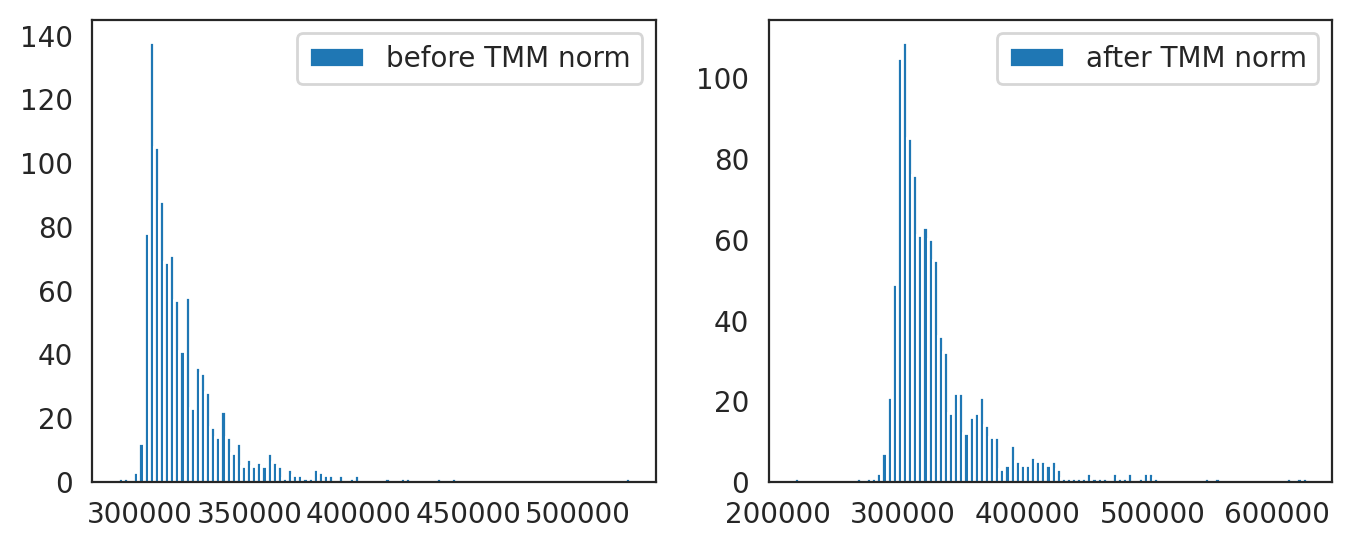

In [8]:
""" The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(8,3))
axes[0].hist(expression_quantified.X.sum(axis=1), bins=100, log=False, label="before TMM norm")
axes[1].hist(ingestion.tmmNormalization(expression_quantified.X.T).T.sum(axis=1), bins=100, log=False, label="after TMM norm")
axes[0].legend()
axes[1].legend()
plt.show()

### Check Gene Expr Consistency, Replication Consistency

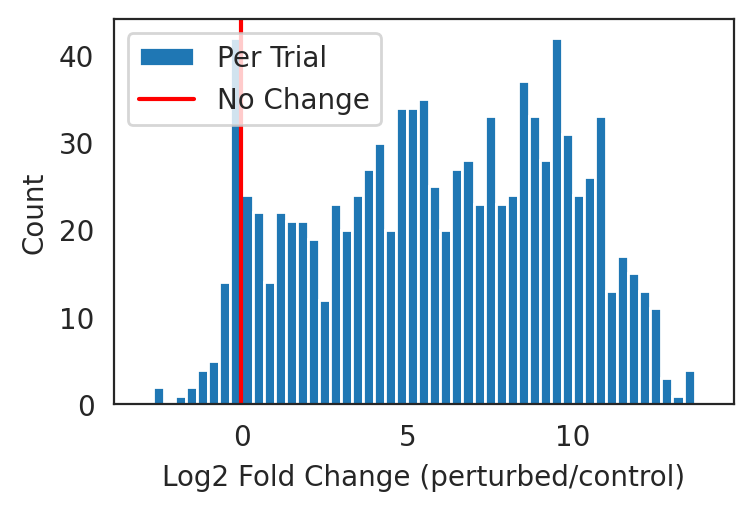

Counter({'Yes': 936, 'NA': 6, 'No': 70})

In [9]:
# If verbose is set to True, display disconcordant trials and their controls
status, logFC = ingestion.checkConsistency(expression_quantified, 
                                           perturbationType="overexpression", 
                                           group=None,
                                           verbose=False) 
expression_quantified.obs["consistentW/Perturbation"] = status
expression_quantified.obs["logFC"] = logFC
Counter(status)

In [10]:
TFqPCR = set(pd.read_csv("not_ready/ko_esc/nakatakeSupplemental3.csv")['TF'])

In [11]:
expression_quantified.obs['qPCRExamined'] = [True if i in TFqPCR else False for i in expression_quantified.obs.perturbation]

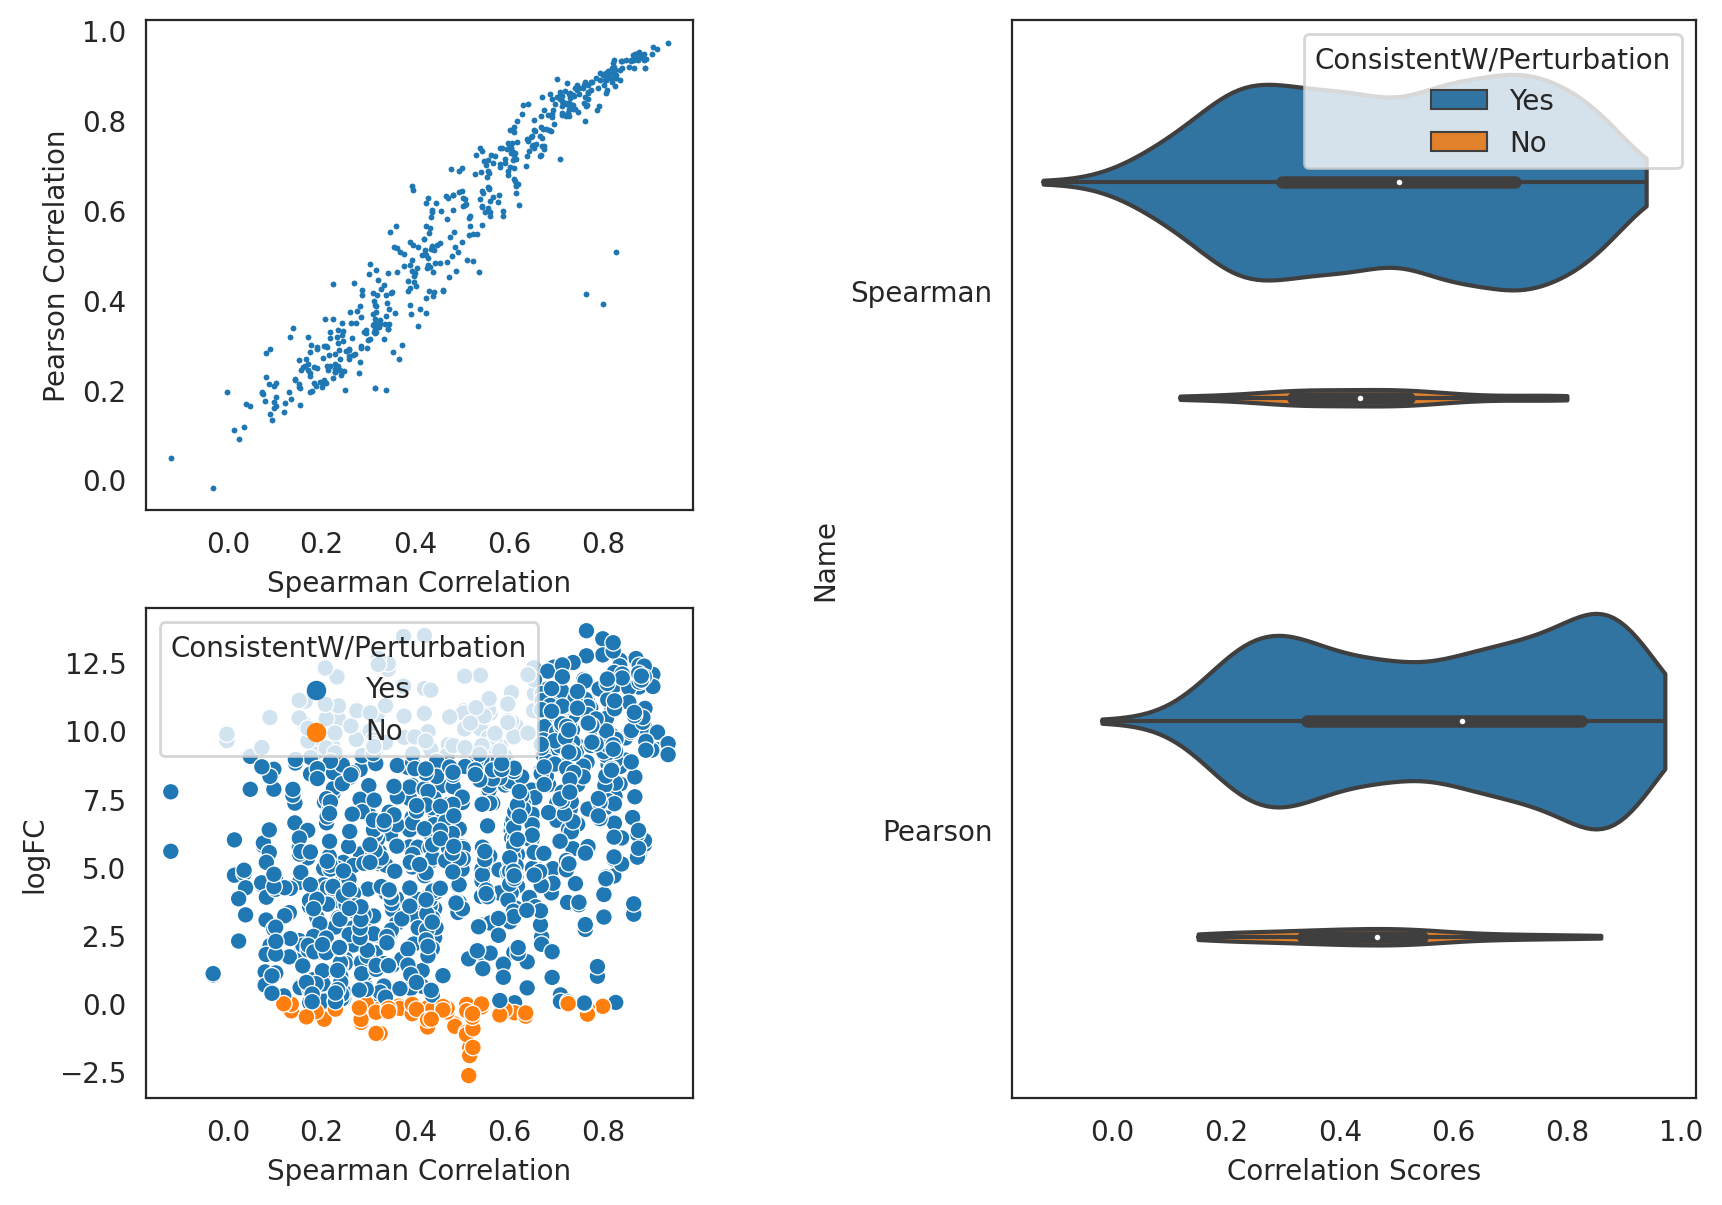

In [12]:
correlations = ingestion.computeCorrelation(expression_quantified, verbose=True)
expression_quantified.obs["spearmanCorr"] = correlations[0]
expression_quantified.obs[ "pearsonCorr"] = correlations[1]

In [13]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv("setup/tfList.csv", index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv("setup/epiList.csv", index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

"""
Download from https://www.sciencedirect.com/science/article/pii/S2211124720306082 """
annotation = pd.read_csv("not_ready/ko_esc/nakatakeData.csv").iloc[:, [0,1]]
annotation = dict([tuple(i) for i in annotation.to_numpy().tolist()])

perturbagenList = np.array(sorted(set(expression_quantified.obs.perturbation) - set(controls)))
perturbagenStatus = np.array(["Yes" if p in TFDict or p in EpiDict else "No" for p in perturbagenList])
colorDict = {'No': '#1f77b4', 'Yes': '#ff7f0e'}
perturbagenColor = [colorDict[p] for p in perturbagenStatus]

In [14]:
diffExprGene, mutualInfo, logFCMean, logFCNorm2, logFCMedian = ingestion.quantifyEffect(adata=expression_quantified, 
                                                                                      fname="setup/nakatakeFullTranscriptome.csv")

In [15]:
def checkMetricCorrelation(metric1: np.ndarray, metric2: np.ndarray, n1: str, n2: str): 
    plt.figure(figsize=(3,3))
    plt.scatter(metric1, 
                metric2, 
                s=1, 
                label=f"{spearmanr(metric1, metric2)[0]:.3f}")
    plt.xlabel(n1)
    plt.ylabel(n2)
    plt.legend()
    plt.show()

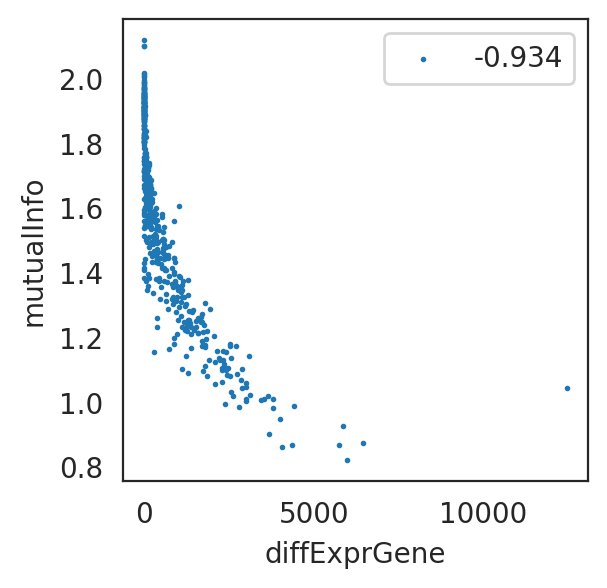

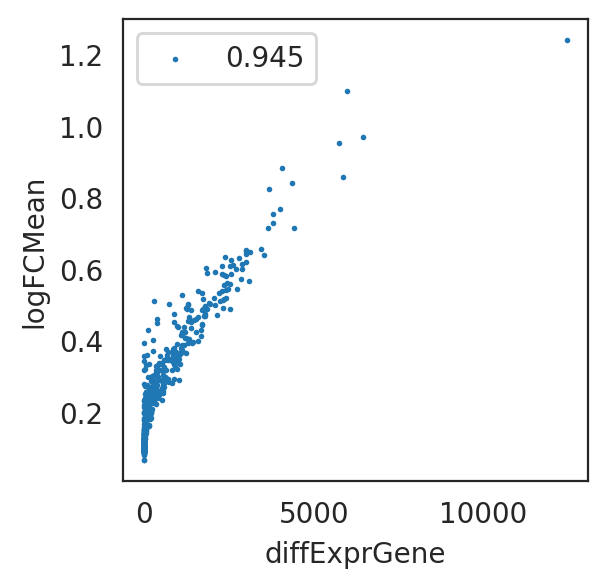

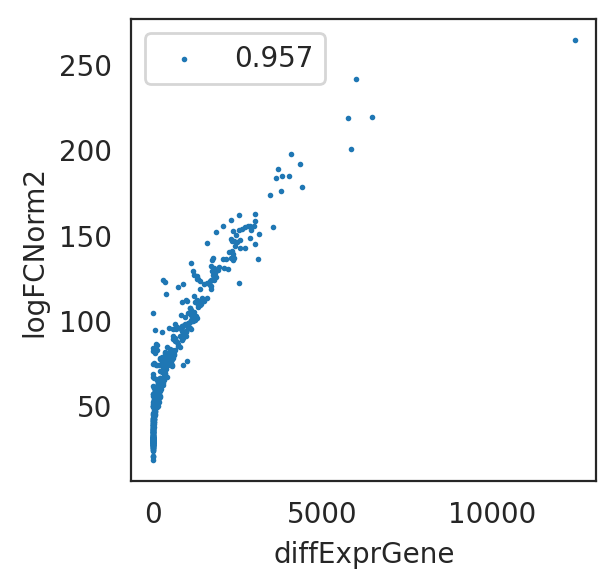

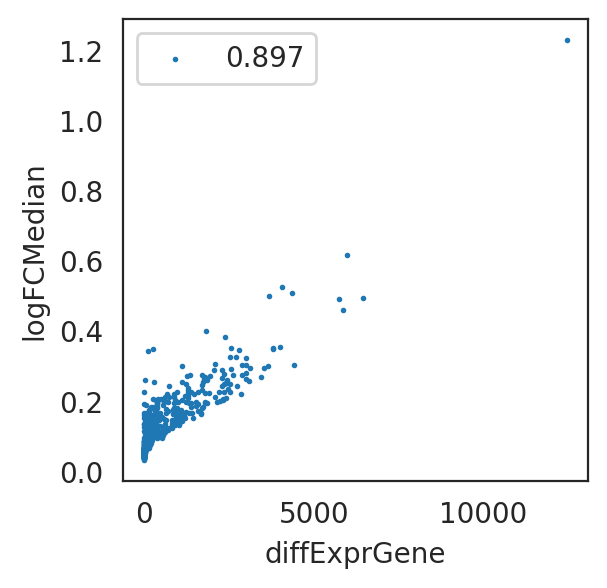

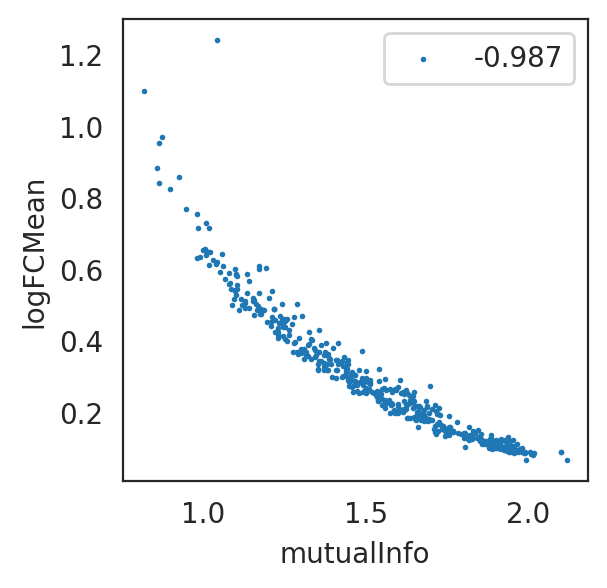

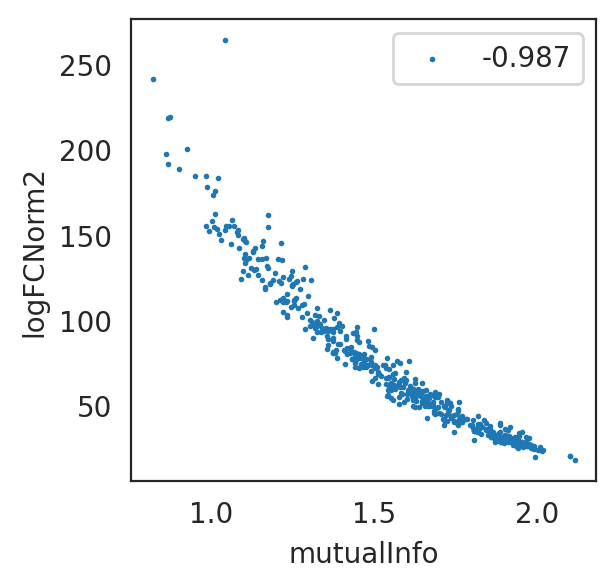

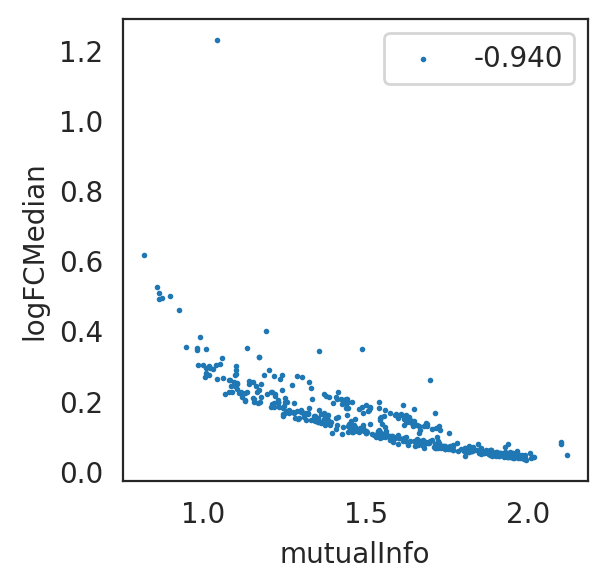

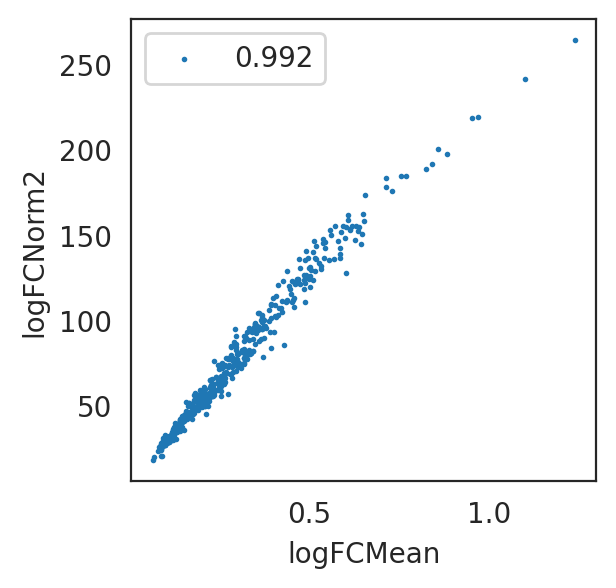

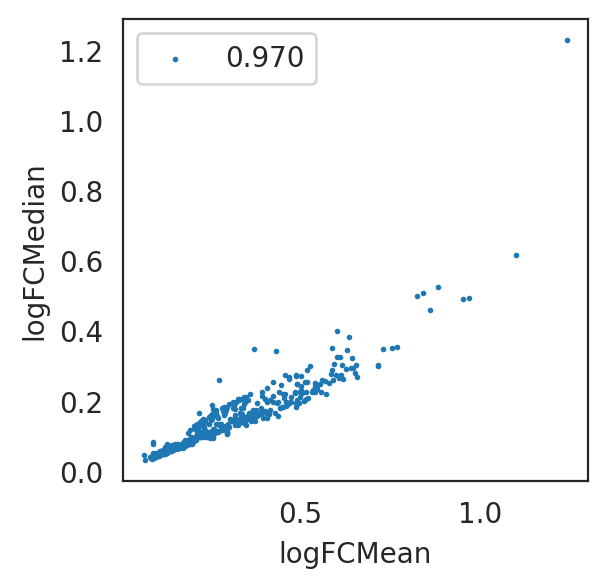

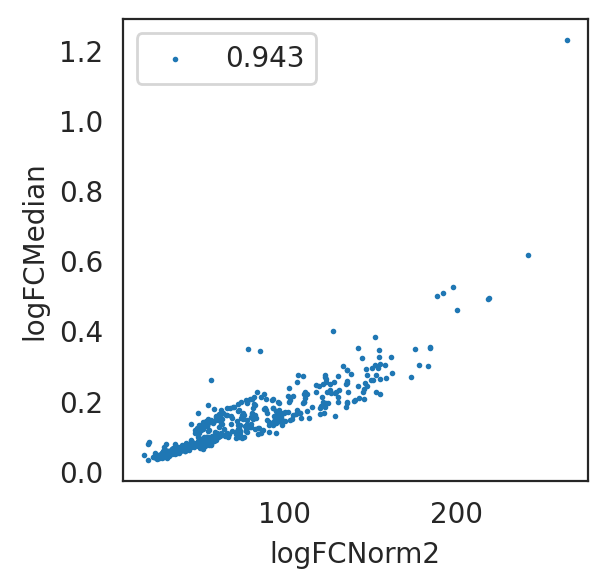

In [16]:
listOfMetrics = ["diffExprGene", "mutualInfo", "logFCMean", "logFCNorm2", "logFCMedian"]
for (p1, p2) in it.combinations(listOfMetrics, r=2):
    checkMetricCorrelation(eval(p1), eval(p2), p1, p2)

Counter({'cytokine relrated': 12,
         'general transcription related': 8,
         'cofactor': 15,
         'others': 12,
         'putative transcrption factor': 18,
         'RNA binding': 5,
         'DNA repairings': 8,
         'DNA binding': 8,
         'Histone': 2,
         'circadian': 1})

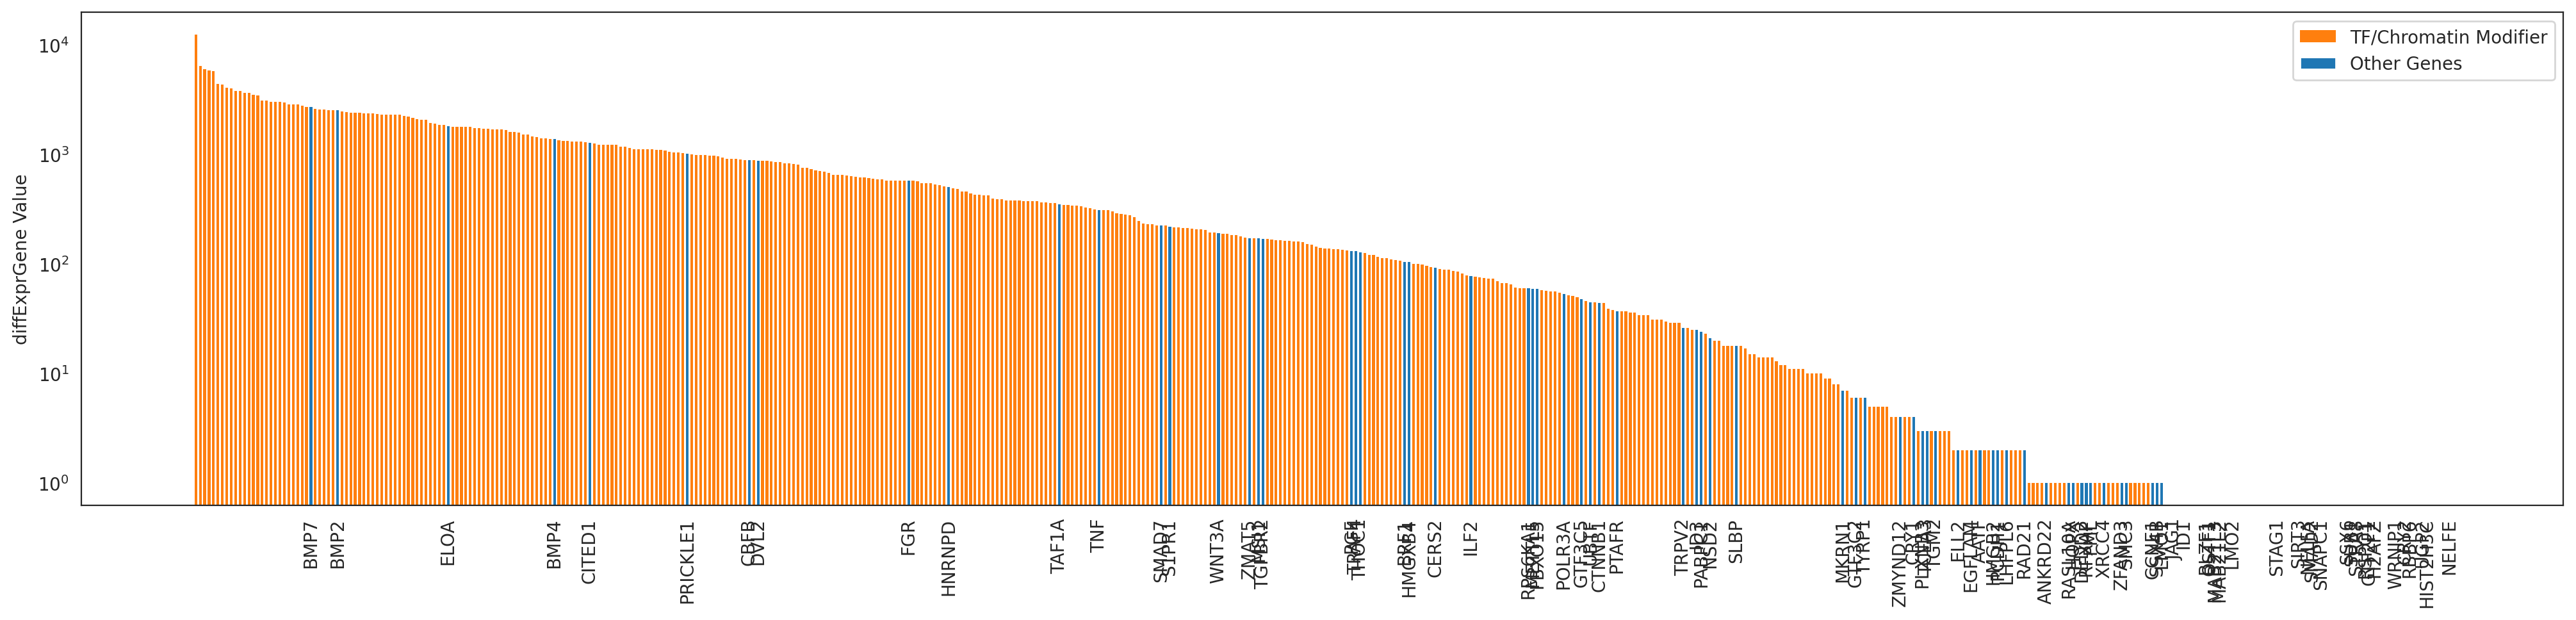

Counter({'cytokine relrated': 12,
         'general transcription related': 8,
         'cofactor': 15,
         'putative transcrption factor': 18,
         'others': 12,
         'RNA binding': 5,
         'DNA repairings': 8,
         'DNA binding': 8,
         'Histone': 2,
         'circadian': 1})

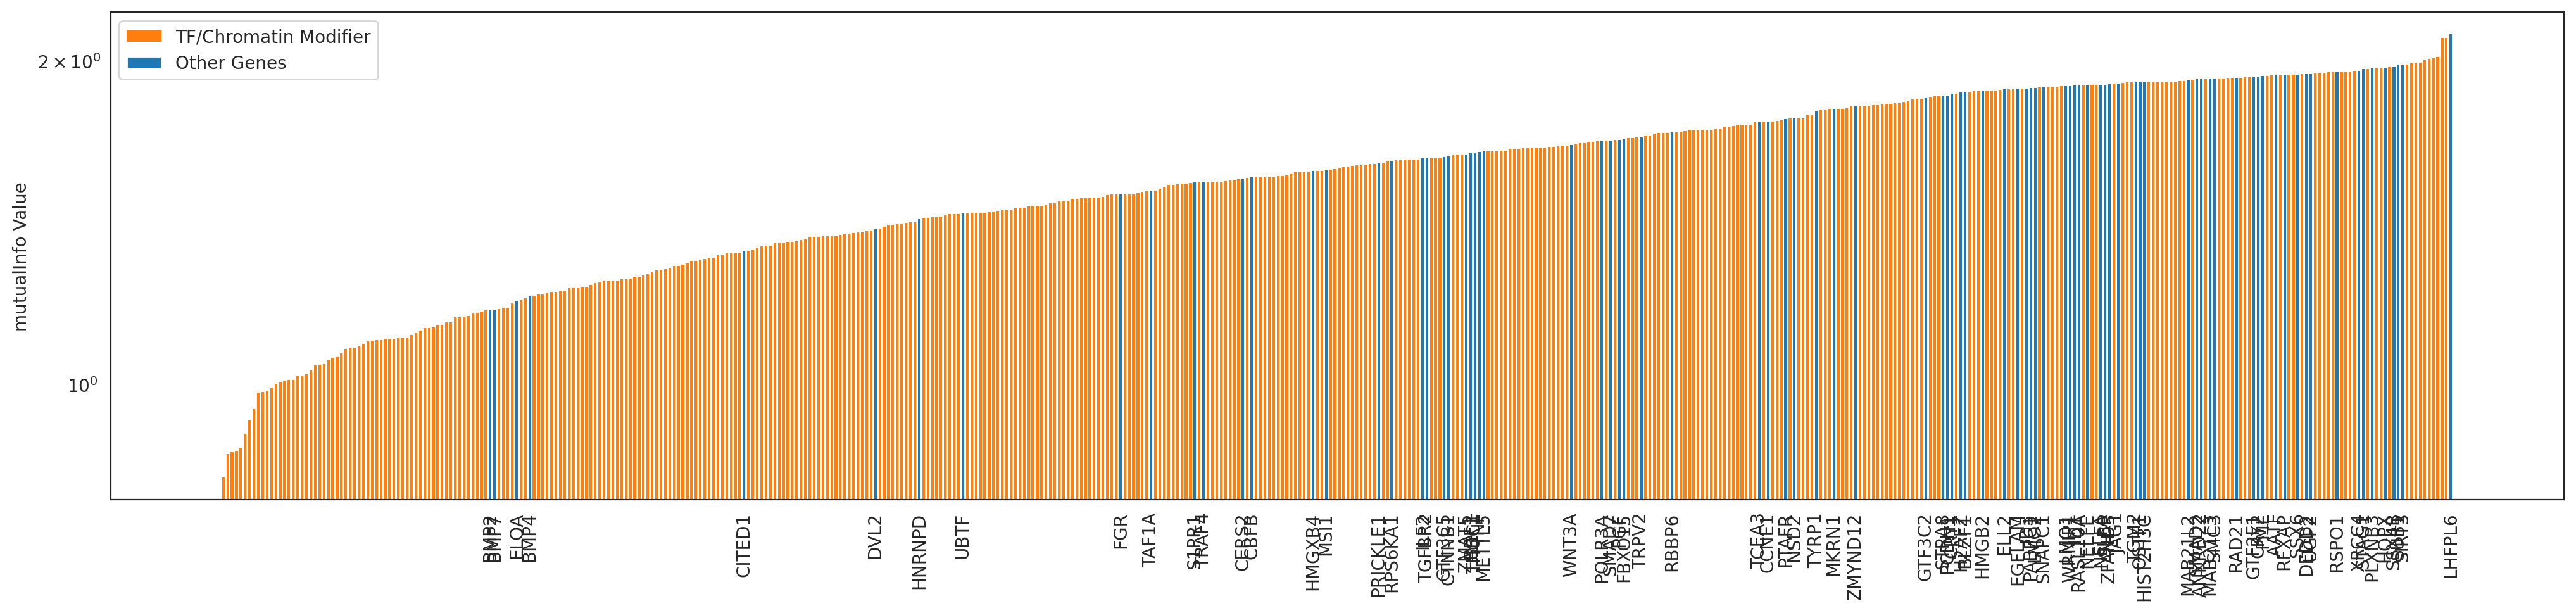

Counter({'cytokine relrated': 12,
         'general transcription related': 8,
         'cofactor': 15,
         'putative transcrption factor': 18,
         'others': 12,
         'DNA repairings': 8,
         'RNA binding': 5,
         'DNA binding': 8,
         'Histone': 2,
         'circadian': 1})

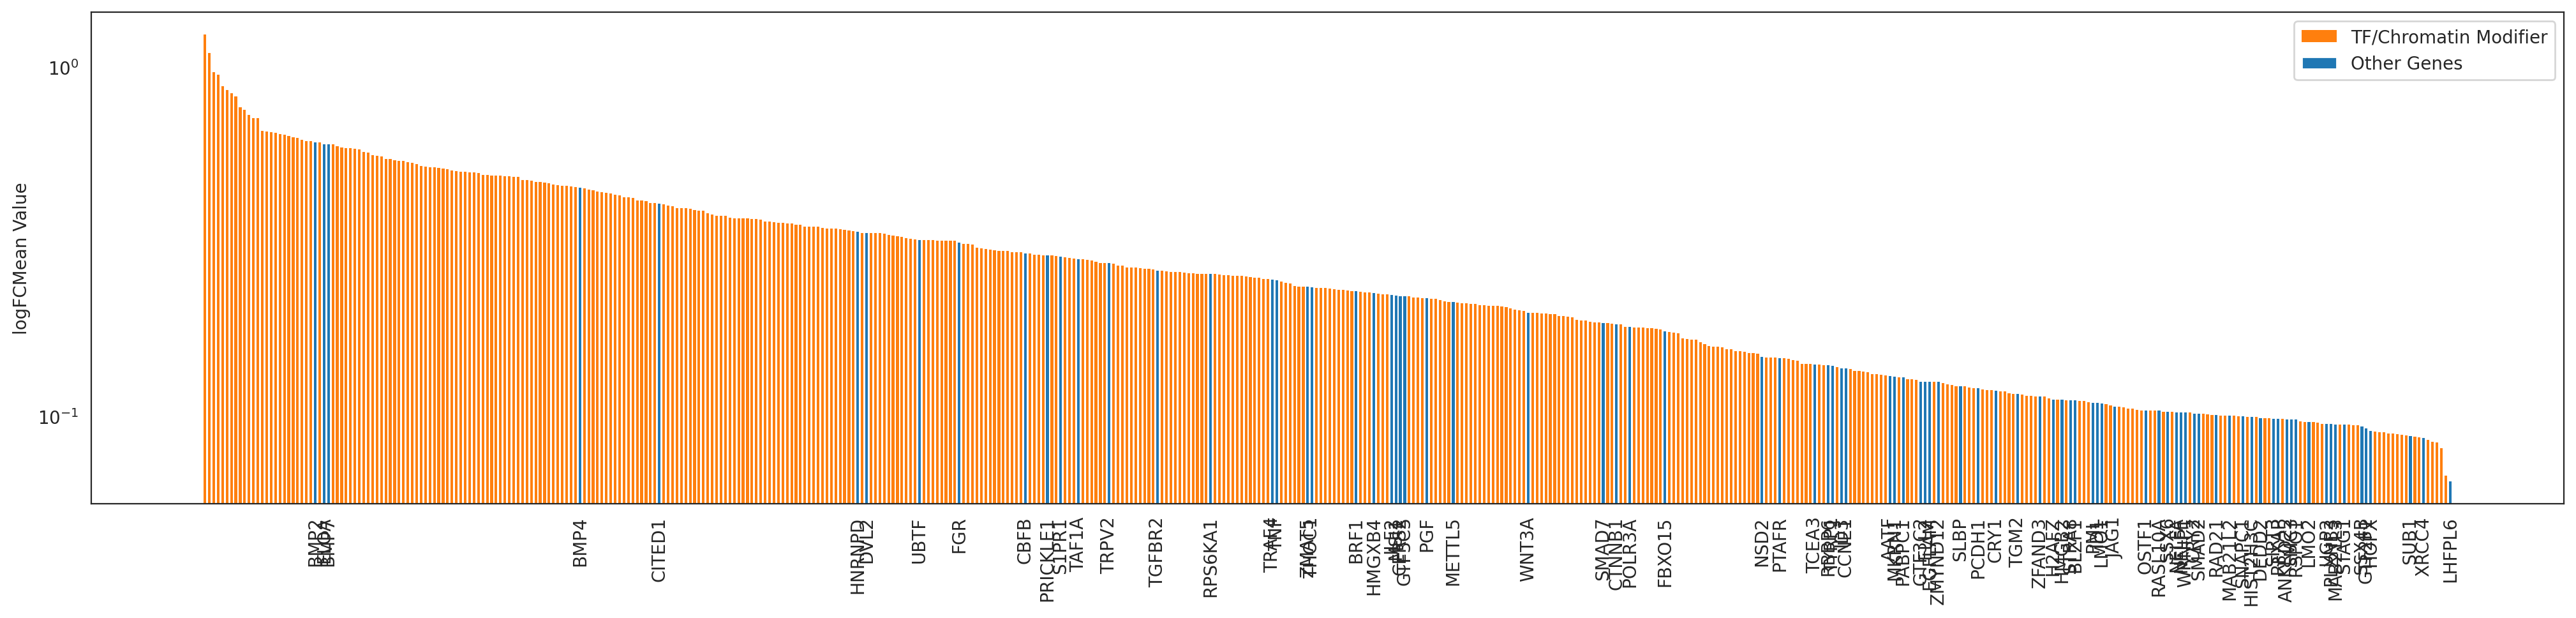

Counter({'cytokine relrated': 12,
         'general transcription related': 8,
         'cofactor': 15,
         'putative transcrption factor': 18,
         'others': 12,
         'DNA repairings': 8,
         'RNA binding': 5,
         'DNA binding': 8,
         'Histone': 2,
         'circadian': 1})

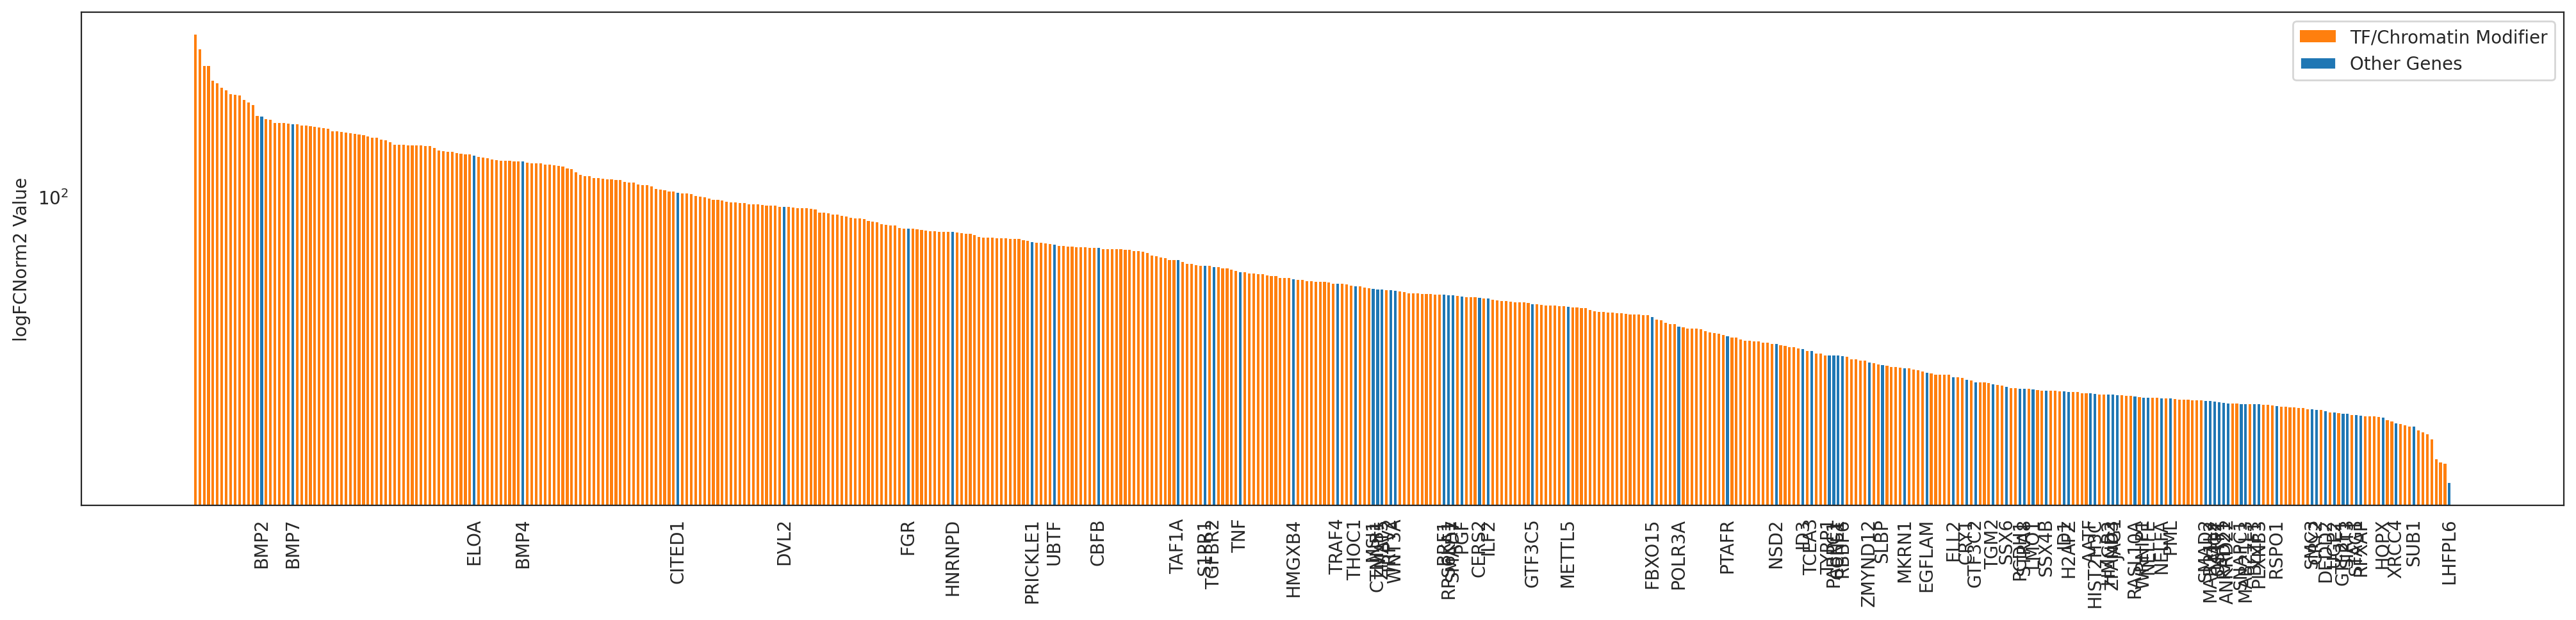

Counter({'general transcription related': 8,
         'cytokine relrated': 12,
         'DNA repairings': 8,
         'cofactor': 15,
         'others': 12,
         'putative transcrption factor': 18,
         'DNA binding': 8,
         'RNA binding': 5,
         'Histone': 2,
         'circadian': 1})

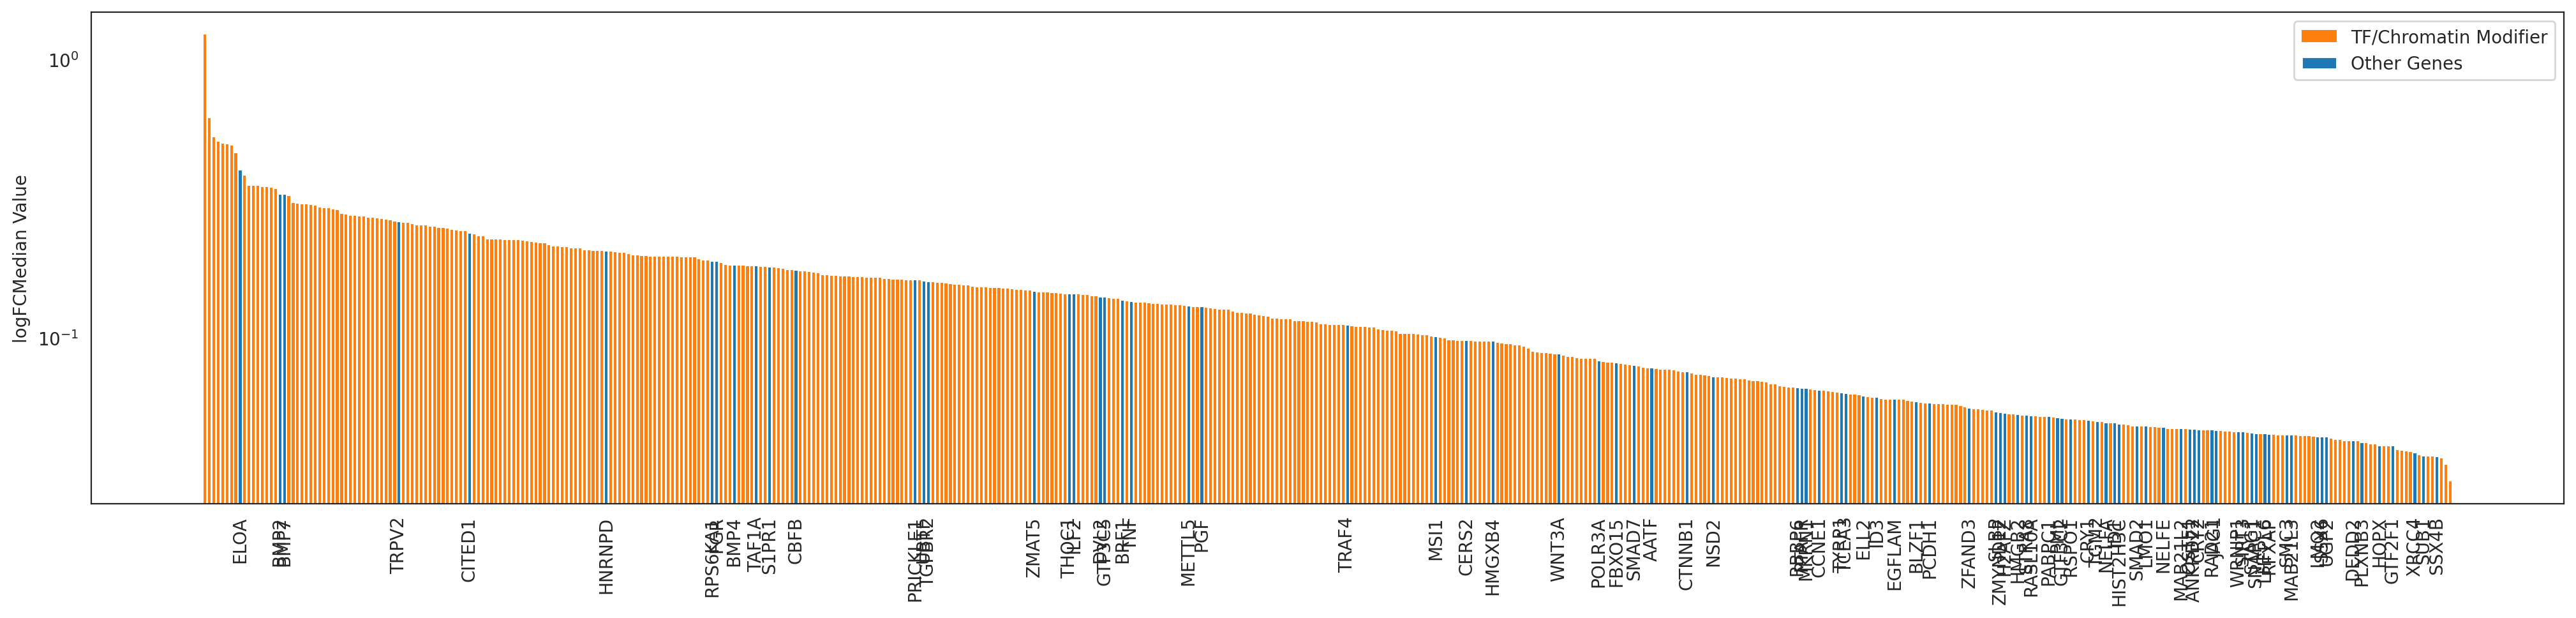

In [17]:
for idx, p1 in enumerate(listOfMetrics):
    plt.figure(figsize=(25,5))
    index = np.argsort(eval(p1))[::-1]
    if idx == 1:
        index = index[::-1]
    plt.bar(np.arange(diffExprGene.shape[0]), eval(p1)[index], width=0.6, 
            linewidth=0, color=np.array(perturbagenColor)[index], log=True, label="TF/Chromatin Modifier")
    plt.bar(range(0), 0, label="Other Genes")
    otherGene = np.array([(i,p) for i,p in enumerate(perturbagenList[index]) if perturbagenStatus[index][i] == 'No'])

    # display([(p,annotation[p]) for i,p in otherGene])
    display(Counter([annotation[p] for i,p in otherGene]))
    plt.legend()
    plt.ylabel(f"{p1} Value")
    plt.xticks(otherGene[:,0].astype(int), otherGene[:,1], rotation=90, fontsize=10)
    plt.show()

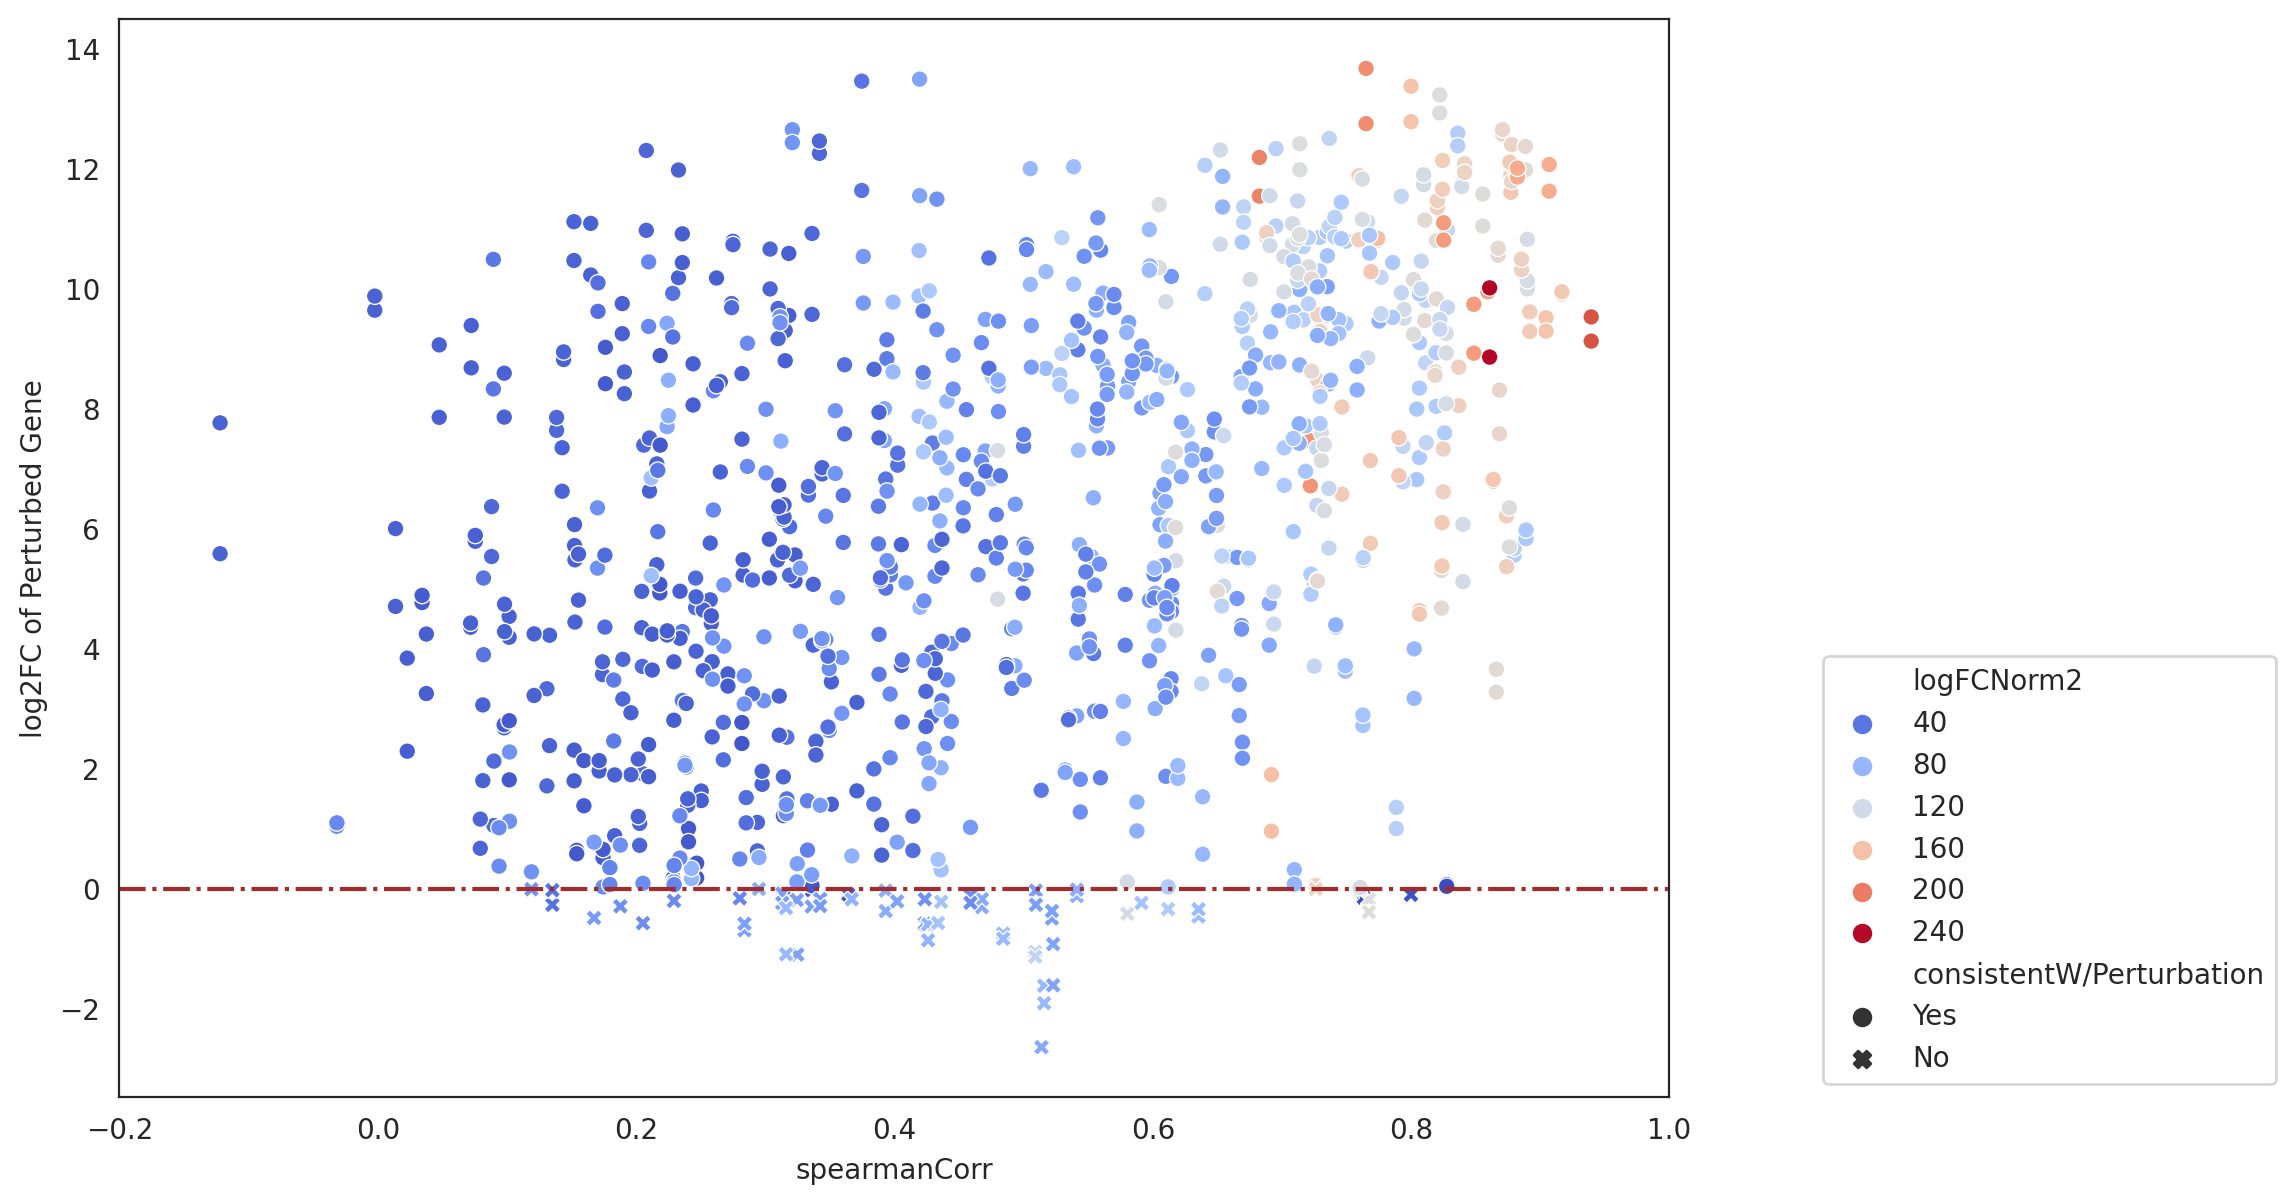

In [18]:
expression_quantified.obs['DEG'] = np.full(expression_quantified.n_obs, -999, dtype=np.float64)
expression_quantified.obs['MI' ] = np.full(expression_quantified.n_obs, -999, dtype=np.float64)
expression_quantified.obs['logFCMean'  ] = np.full(expression_quantified.n_obs, -999, dtype=np.float64)
expression_quantified.obs['logFCNorm2' ] = np.full(expression_quantified.n_obs, -999, dtype=np.float64)
expression_quantified.obs['logFCMedian'] = np.full(expression_quantified.n_obs, -999, dtype=np.float64)

for idx, p in enumerate(perturbagenList):
    rows = np.where(expression_quantified.obs.perturbation == p)[0]
    expression_quantified.obs['DEG'][rows] = diffExprGene[idx]
    expression_quantified.obs['MI' ][rows] = mutualInfo[idx]
    expression_quantified.obs['logFCMean'  ][rows] = logFCMean[idx]
    expression_quantified.obs['logFCNorm2' ][rows] = logFCNorm2[idx]
    expression_quantified.obs['logFCMedian'][rows] = logFCMedian[idx]
    
validMat = (expression_quantified.obs['spearmanCorr'] != -999) & (expression_quantified.obs['logFC'] != -999)

plt.figure(figsize=(10, 7))
g =sns.scatterplot(data=expression_quantified.obs[validMat], 
                   x='spearmanCorr', 
                   y='logFC', 
                   style='consistentW/Perturbation', 
                   hue='logFCNorm2', 
                   palette=sns.color_palette("coolwarm", as_cmap=True), 
                   markers=['o', 'X'],
                   legend='brief')
plt.axhline(0, 0, 1, linestyle='-.', color='brown')
g.legend(loc='lower right', bbox_to_anchor=(1.4, 0), ncol=1)
plt.ylabel("log2FC of Perturbed Gene")
plt.xlim([-0.2, 1])
plt.show()

In [41]:
spearmanr(expression_quantified.obs[validMat].spearmanCorr, expression_quantified.obs[validMat].logFCNorm2)

SpearmanrResult(correlation=0.8229160162511452, pvalue=4.4200197090771685e-244)

In [ ]:
subset = expression_quantified.obs[validMat]
subset[(subset.logFC < 0) & (subset.qPCRExamined)]

perturbation  is_control  fraction_missing consistentW/Perturbation  \
LIN28A         LIN28A       False          0.000000                       No   
LIN28A.1       LIN28A       False          0.000000                       No   
POU5F1         POU5F1       False          0.000040                       No   
POU5F1.1       POU5F1       False          0.000120                       No   
POU5F1.2       POU5F1       False          0.000159                       No   
RBBP5           RBBP5       False          0.000000                       No   
RBBP5.1         RBBP5       False          0.000000                       No   
RBBP6           RBBP6       False          0.000000                       No   
RBBP6.1         RBBP6       False          0.000000                       No   
TAF7             TAF7       False          0.000000                       No   
ZNF706         ZNF706       False          0.000000                       No   
ZNF706.1       ZNF706       False          0.000000                       No   

             logFC  qPCRExamined  spearmanCorr  pearsonCorr  DEG        MI  \
LIN28A   -0.083262          True      0.364349     0.268515  0.0  1.989037   
LIN28A.1 -0.098384          True      0.364349     0.268515  0.0  1.989037   
POU5F1   -0.068770          True      0.313933     0.204037  1.0  1.992977   
POU5F1.1 -0.113262          True      0.313933     0.204037  1.0  1.992977   
POU5F1.2 -0.135975          True      0.313933     0.204037  1.0  1.992977   
RBBP5    -0.087791          True      0.763361     0.414150  0.0  2.099266   
RBBP5.1  -0.150588          True      0.763361     0.414150  0.0  2.099266   
RBBP6    -0.269874          True      0.135187     0.178702  0.0  1.714912   
RBBP6.1  -0.026648          True      0.135187     0.178702  0.0  1.714912   
TAF7     -0.025590          True      0.336209     0.199908  0.0  2.003322   
ZNF706   -0.128004          True      0.799899     0.391675  0.0  2.099846   
ZNF706.1 -0.102466          True      0.799899     0.391675  0.0  2.099846   

          logFCMean  logFCNorm2  logFCMedian  
LIN28A     0.089797   24.743813     0.047116  
LIN28A.1   0.089797   24.743813     0.047116  
POU5F1     0.067597   20.248693     0.030559  
POU5F1.1   0.067597   20.248693     0.030559  
POU5F1.2   0.067597   20.248693     0.030559  
RBBP5      0.089130   20.355951     0.076840  
RBBP5.1    0.089130   20.355951     0.076840  
RBBP6      0.139895   38.603741     0.065957  
RBBP6.1    0.139895   38.603741     0.065957  
TAF7       0.089241   24.437431     0.052003  
ZNF706     0.089894   20.772011     0.081724  
ZNF706.1   0.089894   20.772011     0.081724

## Basic EDA

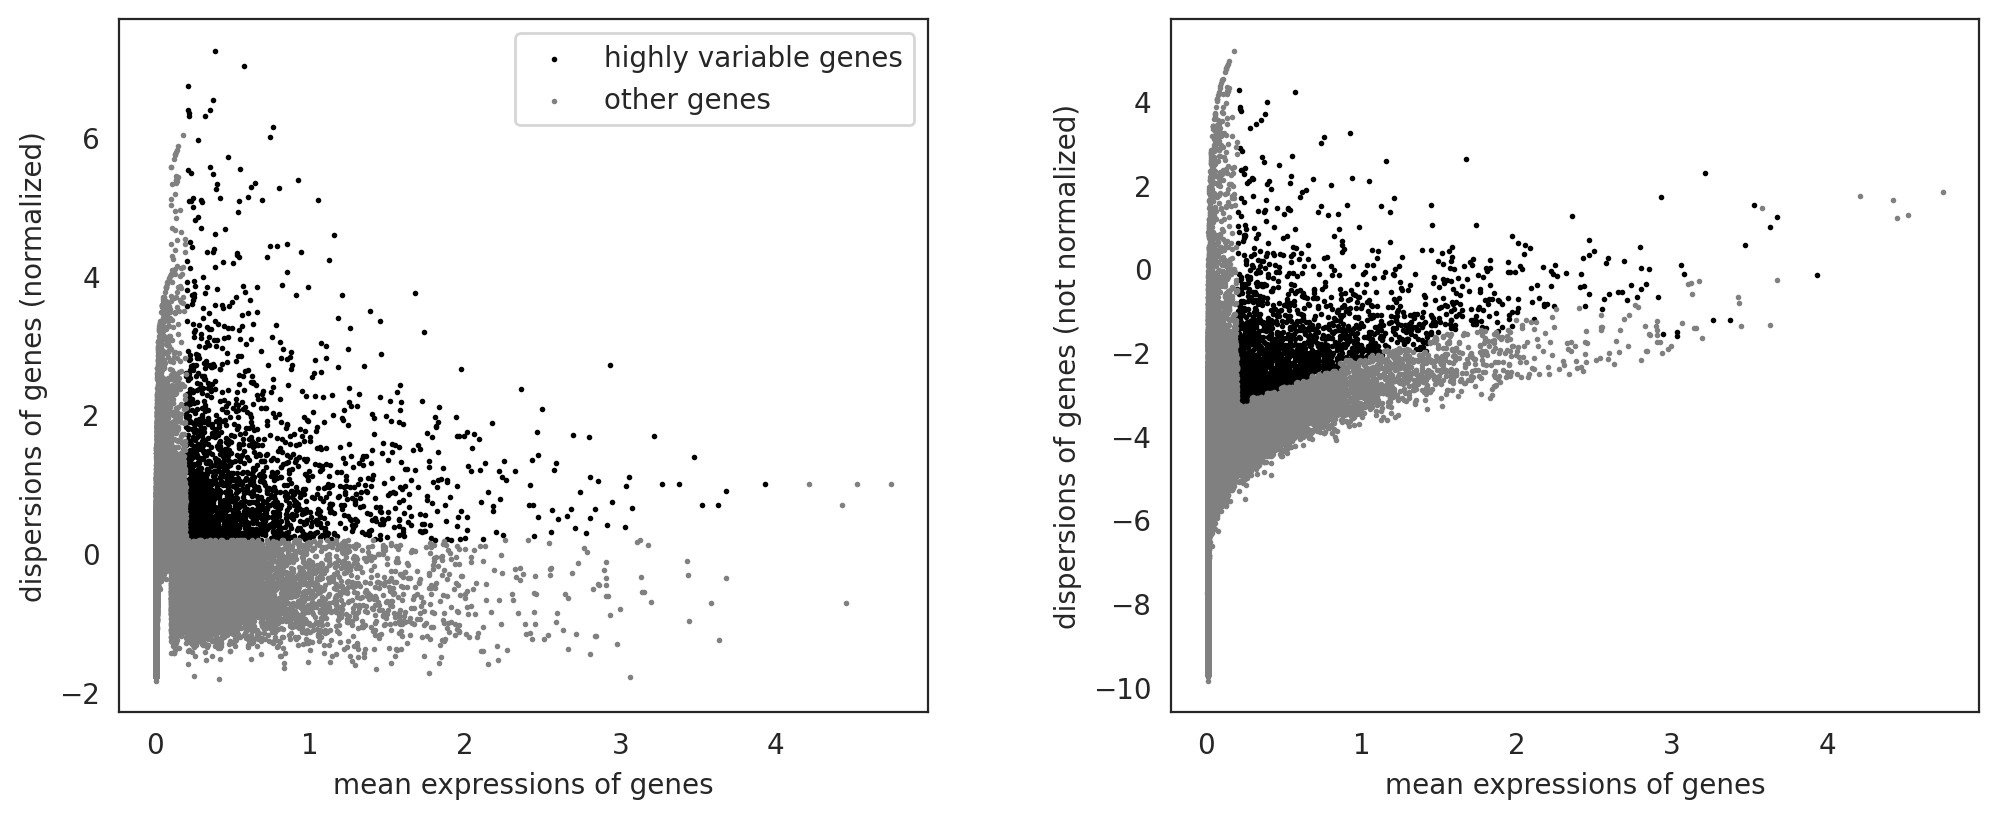

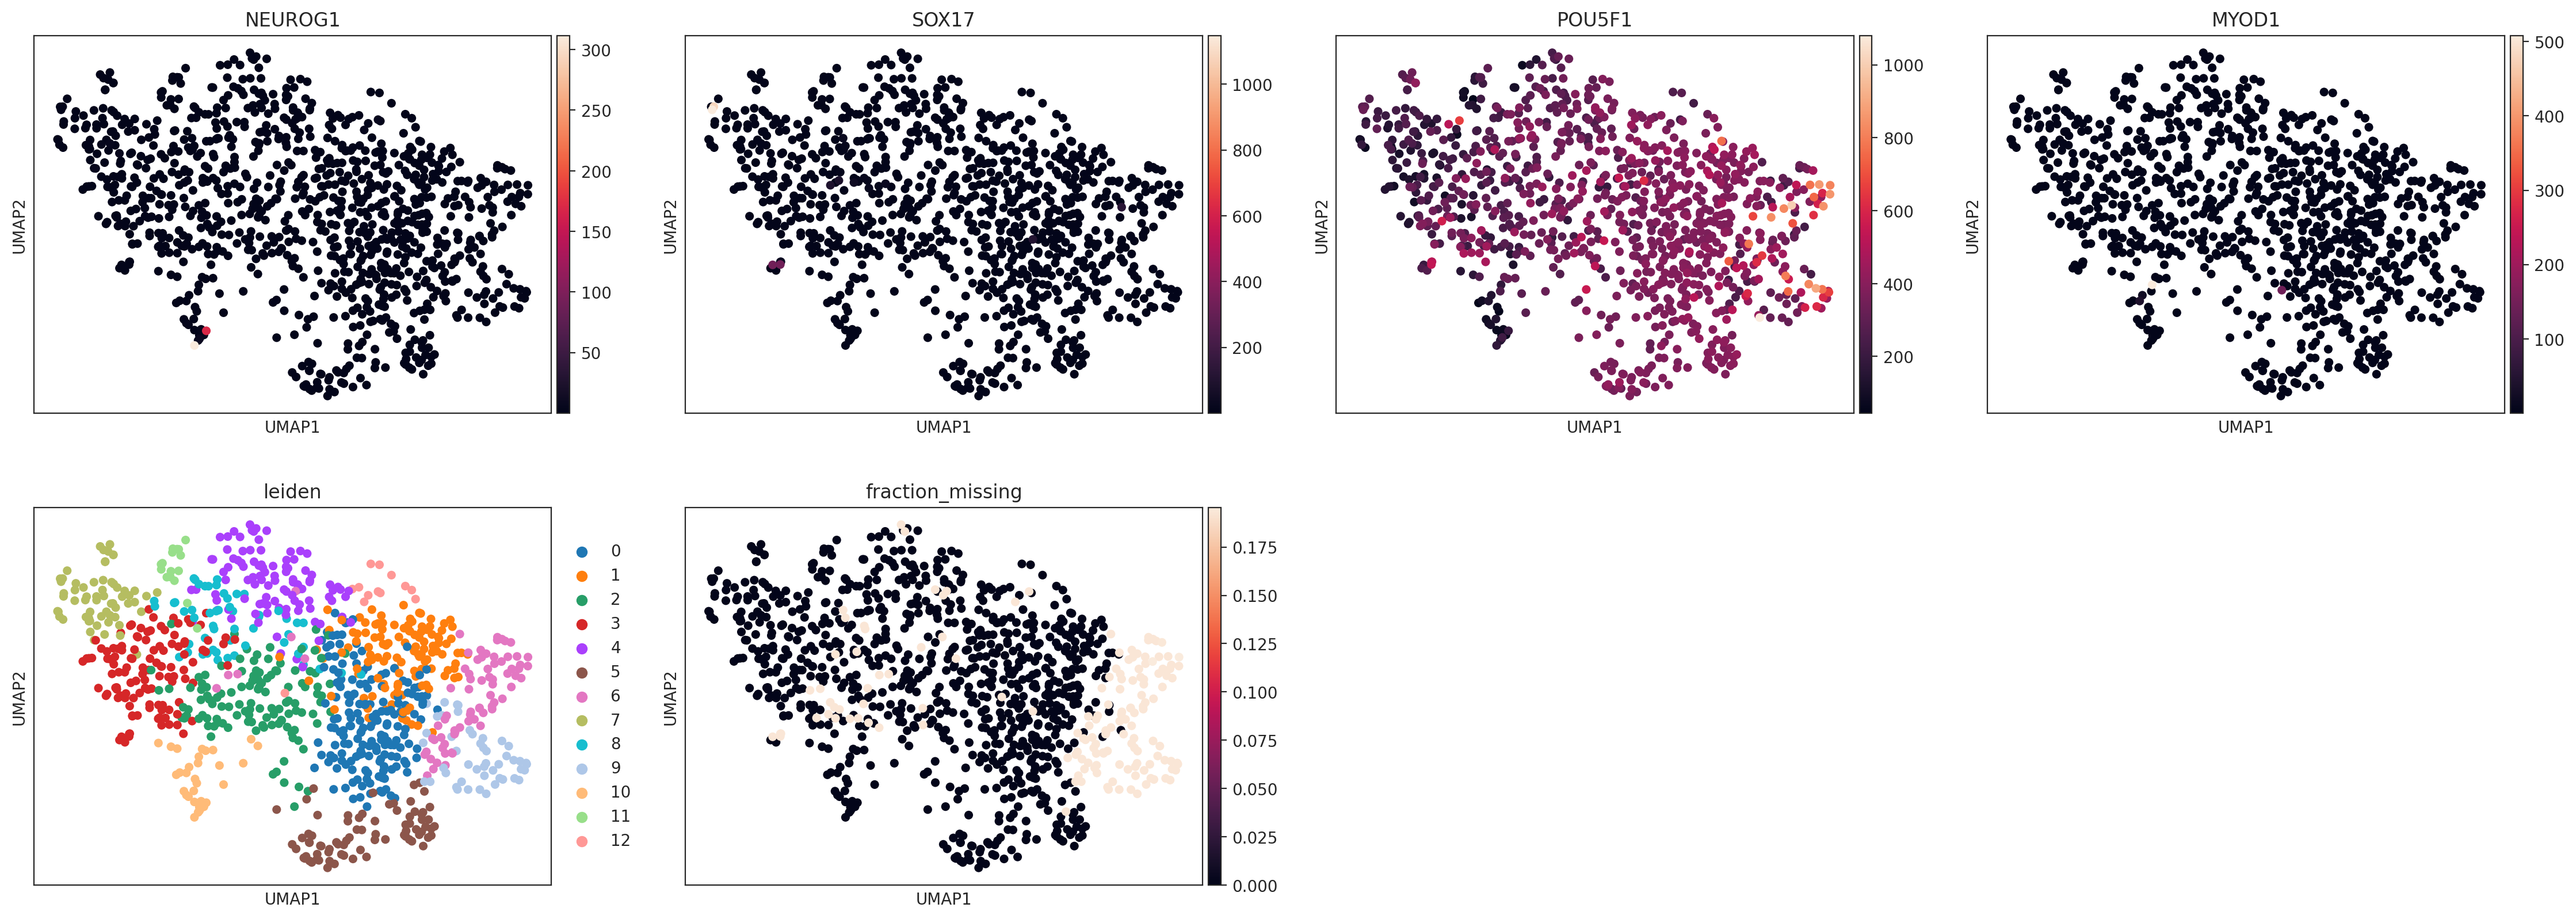

In [20]:
sc.pp.normalize_total(expression_quantified, target_sum=1e4)
sc.pp.log1p(expression_quantified)
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=100)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)
sc.pl.umap(expression_quantified, color = ["NEUROG1", "SOX17", "POU5F1", "MYOD1", "leiden", "fraction_missing"])
# Due to the small number of samples, ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"] = "all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

For quick software tests, we also take some data with as few genes as possible (just those that are perturbed and measured).

In [21]:
perturbed_genes = set(list(expression_quantified.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(expression_quantified.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(expression_quantified.var.index)
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
genes_keep = expression_quantified.var.index[expression_quantified.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
expression_quantified_orig = expression_quantified
# Nakatake data final form
expression_quantified = expression_quantified_orig[:,list(genes_keep)]
expression_quantified.uns["perturbed_and_measured_genes"] = list(perturbed_and_measured_genes)
expression_quantified.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)

expression_quantified = ingestion.describe_perturbation_effect(expression_quantified, "overexpression")

These genes were perturbed but not measured:
{'DUX4'}


In [22]:
try:
    os.makedirs("perturbations/nakatake")
except FileExistsError:
    pass
expression_quantified.write_h5ad("perturbations/nakatake/test.h5ad")